In [3]:
import os
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
# import yaml
from collections import defaultdict

# SVDquartets

In [4]:
proj_dir="/master/nplatt/sch_hae_its-nigeria"
results_dir=f"{proj_dir}/results"

In [5]:
info_df=pd.read_csv(f"{proj_dir}/its-nigeria_samplesheet.csv", sep=",")
info_df

,wgs_id,its_id,sra,species,country,locale,patient,miracidum
0,Sb_NG_ak_1.1,Sb.ng.ak.1.1F,NaN,sbovis,nigeria,ak,1,1
1,Sb_NG_ak_2.1,sb_ng_ak_2.1,NaN,sbovis,nigeria,ak,2,1
2,Sb_NG_ak_2.2,Sb.ng.ak.2.2F,NaN,sbovis,nigeria,ak,2,2
3,Sb_NG_ak_2.3,Sb.ng.ak.2.3F,NaN,sbovis,nigeria,ak,2,3
4,Sb_NG_ak_3.1,Sb.ng.ak.3.1R,NaN,sbovis,nigeria,ak,3,1
...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,sh_ng_os_3_1,NaN,shaematobium,nigeria,osun,3,1
201,c_Sh_NG_os_3_11,Sh.ng.os.3.11F,NaN,shaematobium,nigeria,osun,3,11
202,c_Sh_NG_os_3_5,Sh.ng.os.3.5F,NaN,shaematobium,nigeria,osun,3,5
203,c_Sh_NG_os_3_6,Sh.ng.os.3.6F,NaN,shaematobium,nigeria,osun,3,6


In [6]:
Path(f"{results_dir}/svdq").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/svdq")

In [7]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --singletons \
        --vcf ../filter_genotypes/SH_V3/snvs.ld.vcf \
        --out snvs


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
ilter_genotypes/SH_V3/snvs.ld.vcf
	--out snvs
	--singletons

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
e count in genotypes, for each ALT allele, in the same order as listed">teger,Description="Allel
2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
 entry: ID=AF,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
cription="Maximum likelihood expectation (MLE) for the allele counts (not necessarily the same as the AC), for each ALT allele, in the same order as listed">
 entry: ID=

In [8]:
%%bash

sed 1d snvs.singletons | cut -f1,2 >snvs.singletons.list
wc -l snvs.singletons.list

815603 snvs.singletons.list


In [9]:
%%bash

vcftools \
    --exclude-positions snvs.singletons.list \
    --vcf ../filter_genotypes/SH_V3/snvs.ld.vcf \
    --recode \
    --recode-INFO-all \
    --stdout \
    >snvs.autosomes.ld.informative.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
ilter_genotypes/SH_V3/snvs.ld.vcf
	--exclude-positions snvs.singletons.list
	--recode-INFO-all
codee
	--stdout

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
at least 2 parts in FORMAT entry: ID=RGQ,Number=1,Type=Integer,Description="Unconditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
rts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
ing: Expected at least 2 parts in INFO entry: ID=AF,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
ry:

In [12]:
!ln -s snvs.autosomes.ld.informative.vcf svdq.vcf

In [ ]:
%%bash 

#convert to nexus
~/sch_hae_its-nigeria/bin/vcf2phylip/vcf2phylip.py -i svdq.vcf -r -n -p
ln -s svdq.min4.nexus svdq.nexus

In [14]:
%%bash

conda run -n bcftools bcftools query -l svdq.vcf >svdq.samples.list

In [15]:
%%bash 

echo """

begin paup;
    
    log start file=svdq.log replace;

    svdq evalQuartets=random
         nquartets=10000000
         nthreads=192
         bootstrap=standard
         nreps=100
         treeFile=svdq_boottrees.nwk
         format=newick
         seed=12345
         replace=yes
         ;

    savetrees
        file=svdq_constree.nwk
        format=newick
        supportValues=Both
        maxDecimals=2
        ;
end;

""" >svdq_block.nexus

In [ ]:
~/sch_hae_its-nigeria/bin/paup4a168_ubuntu64

In [ ]:
execute svdq.nexus

In [ ]:
execute svdq_block.nexus

In [20]:
from Bio import Phylo

tree = Phylo.read("svdq_constree.nex", "nexus")

for clade in tree.find_clades():
    if clade.is_terminal():
        continue

    # Determine support: prefer confidence; else try numeric name
    support = None
    if getattr(clade, "confidence", None) is not None:
        support = float(clade.confidence)
    else:
        # If internal node name is numeric, treat it as support
        if clade.name is not None:
            try:
                support = float(clade.name)
            except Exception:
                pass

    # Write support into name (as int when possible), and clear confidence
    if support is not None:
        clade.name = str(int(support)) if support.is_integer() else str(support)
        clade.confidence = None  # prevent duplication on write

Phylo.write(tree, "svdq_constree.nwk", "newick")

1

In [21]:
%%bash
conda run -n nwed nw_ed svdq_constree.nwk 'i & b<=50' o > svdq_constree.bs50.nwk

In [27]:
%%bash
cat ../combined/merged.csv | sed 's/,/\t/g' | cut -f1,4,5,6,17,19,22 >annotations.tsv

In [28]:
info_df

,wgs_id,its_id,sra,species,country,locale,patient,miracidum
0,Sb_NG_ak_1.1,Sb.ng.ak.1.1F,NaN,sbovis,nigeria,ak,1,1
1,Sb_NG_ak_2.1,sb_ng_ak_2.1,NaN,sbovis,nigeria,ak,2,1
2,Sb_NG_ak_2.2,Sb.ng.ak.2.2F,NaN,sbovis,nigeria,ak,2,2
3,Sb_NG_ak_2.3,Sb.ng.ak.2.3F,NaN,sbovis,nigeria,ak,2,3
4,Sb_NG_ak_3.1,Sb.ng.ak.3.1R,NaN,sbovis,nigeria,ak,3,1
...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,sh_ng_os_3_1,NaN,shaematobium,nigeria,osun,3,1
201,c_Sh_NG_os_3_11,Sh.ng.os.3.11F,NaN,shaematobium,nigeria,osun,3,11
202,c_Sh_NG_os_3_5,Sh.ng.os.3.5F,NaN,shaematobium,nigeria,osun,3,5
203,c_Sh_NG_os_3_6,Sh.ng.os.3.6F,NaN,shaematobium,nigeria,osun,3,6


In [7]:
df=pd.read_csv("../combined/raw.merged.csv", sep=",", header=0)
df = df[["wgs_id", "species", "country", "locale", "its_class", "mitotype", "adm2", "sh_population"]]
df


,wgs_id,species,country,locale,its_class,mitotype,adm2,sh_population
0,Sb_NG_ak_1.1,sbovis,nigeria,ak,SBxSB,SB,0.000010,NaN
1,Sb_NG_ak_2.1,sbovis,nigeria,ak,SBxSB,SB,0.000010,NaN
2,Sb_NG_ak_2.2,sbovis,nigeria,ak,SBxSB,SB,0.000010,NaN
3,Sb_NG_ak_2.3,sbovis,nigeria,ak,SBxSB,SB,0.000010,NaN
4,Sb_NG_ak_3.1,sbovis,nigeria,ak,SBxSB,SB,0.000010,NaN
...,...,...,...,...,...,...,...,...
200,Sh_NG_os_3_1,shaematobium,nigeria,osun,SHxSH,SH,0.999980,S
201,c_Sh_NG_os_3_11,shaematobium,nigeria,osun,SHxSH,SH,0.996946,S
202,c_Sh_NG_os_3_5,shaematobium,nigeria,osun,SHxSH,SH,0.999980,S
203,c_Sh_NG_os_3_6,shaematobium,nigeria,osun,SHxSH,SH,0.999980,S


In [8]:
df.loc[df["species"] == "margrebowiei"]

,wgs_id,species,country,locale,its_class,mitotype,adm2,sh_population
150,ERR310940,margrebowiei,zambia,na,NaN,SM,NaN,NaN


In [19]:
import io
from Bio import Phylo
import toytree
import toyplot
import toyplot.png
import toyplot.html

NEWICK_FILE = "svdq_constree.nwk"
OUTGROUP = "ERR310940"

# --- Root the tree using Biopython (robust + simple), then hand to toytree ---
tree = Phylo.read(NEWICK_FILE, "newick")
if any(term.name == OUTGROUP for term in tree.get_terminals()):
    tree.root_with_outgroup(OUTGROUP)

buf = io.StringIO()
Phylo.write(tree, buf, "newick")
newick_str = buf.getvalue()

# --- Draw with toytree ---
tt = toytree.tree(newick_str)

canvas = toyplot.Canvas(width=900, height=600)
axes = canvas.cartesian(bounds=(50, 880, 20, 580))

# Hide axes and ticks entirely
axes.show = False

# Basic rectangular tree with tip names
tt.draw(
    axes=axes,
    layout="r",            # rectangular
    node_sizes=0,
    tip_labels_align=False, # align names in a neat column
    tip_labels=False,
    edge_widths=1.0,
)

# Save outputs
# toyplot.html.render(canvas, "svdq_constree_basic.html")
# toyplot.png.render(canvas, "svdq_constree_basic.png")

(None,
 <toytree.drawing.src.mark_toytree.ToyTreeMark at 0x2b9000682710>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="600.0px" viewBox="0 0 900.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3324565f84c448a38d515f97abfcbe78">

In [159]:
# pip install toytree toyplot biopython pandas

import io
import pandas as pd
from Bio import Phylo
import toytree
import toyplot
import toyplot.png
import toyplot.html

NEWICK_FILE = "svdq_constree.bs50.nwk"
OUTGROUP = "ERR310940"

# Example df
# df = pd.DataFrame({
#     "wgs_id": ["Sb_NG_ak_1.1", "Sb_NG_ak_2.1", "Sb_NG_ak_2.2"],
#     "its_class": ["SBxSB", "SBxSB", "SBxSB"]
# })

# --- Root the tree using Biopython ---
tree = Phylo.read(NEWICK_FILE, "newick")
if any(term.name == OUTGROUP for term in tree.get_terminals()):
    tree.root_with_outgroup(OUTGROUP)

buf = io.StringIO()
Phylo.write(tree, buf, "newick")
newick_str = buf.getvalue()

# --- Create the Toytree object ---
tt = toytree.tree(newick_str)

In [160]:
# --- Draw the tree ---
canvas = toyplot.Canvas(width=900, height=600)
axes = canvas.cartesian(bounds=(50, 880, 20, 580))
axes.show = False

# Draw base tree
m = tt.draw(
    axes=axes,
    layout="r",
    node_sizes=0,
    tip_labels=False,
    edge_widths=1.0,
)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="600.0px" viewBox="0 0 900.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t32005b2ba5b94b9f9b6fdbb71132123a">

/tmp/ipykernel_36688/823332637.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = cm.get_cmap(cmap)


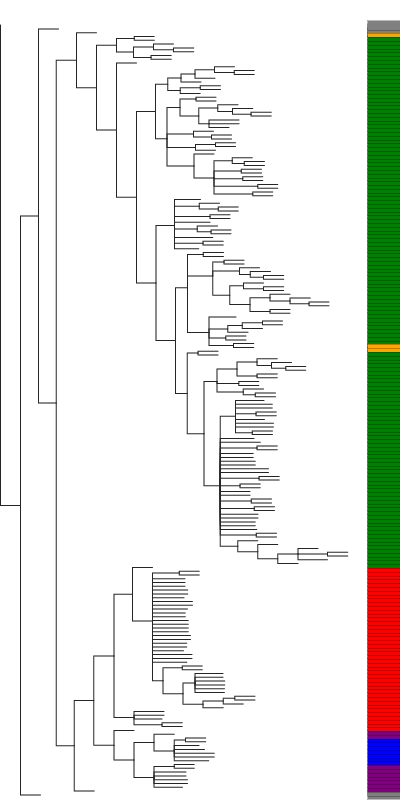

In [158]:
# pip install toytree toyplot biopython pandas matplotlib

import io
import pandas as pd
from Bio import Phylo
import toytree
import toyplot
import toyplot.svg
import matplotlib.cm as cm
import matplotlib.colors as mcolors

NEWICK_FILE = "svdq_constree.bs50.nwk"
OUTGROUP = "ERR310940"

# df must have columns: ["wgs_id", "its_class", "mitotype", "species", "adm2"]

# -------------------------
# 1) Manual categorical colors
# -------------------------
species_colors = {
    "sbovis": "red",
    "shaematobium": "green",
    "sbxsc": "purple",
    "scurassoni": "blue",
    "shxsb": "orange",
    "intercalatum": "grey",
    "guineensis": "grey",
    "matthei": "grey",
    "margrebowiei": "grey",
}
its_class_colors = {
    "SBxSB": "red",
    "SHxSH": "green",
    "SHxSC": "yellow",
    "SCxSC": "blue",
}
mitotype_colors = {
    "SB": "red",
    "SC": "blue",
    "SH": "green",
}

# -------------------------
# 2) Helper functions
# -------------------------
def map_categorical_colors(series, mapping_dict):
    """Map categorical values via user dict; NaN/unmapped -> white."""
    s = series.astype("string")
    return [mapping_dict.get(val, "white") if pd.notna(val) else "white" for val in s]

def map_numeric_cmap(series, cmap="viridis", vmin=0.0, vmax=1.0):
    """Map numeric values to a matplotlib colormap; NaN -> white."""
    vals = pd.to_numeric(series, errors="coerce")
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_func = cm.get_cmap(cmap)
    colors = []
    for v in vals:
        if pd.isna(v):
            colors.append("white")
        else:
            rgba = cmap_func(norm(v))
            colors.append(mcolors.to_hex(rgba))
    return colors

# -------------------------
# 3) Root tree and create toytree object
# -------------------------
tree = Phylo.read(NEWICK_FILE, "newick")
if any(term.name == OUTGROUP for term in tree.get_terminals()):
    tree.root_with_outgroup(OUTGROUP)

buf = io.StringIO()
Phylo.write(tree, buf, "newick")
newick_str = buf.getvalue()
tt = toytree.tree(newick_str)
tip_order = tt.get_tip_labels()

# -------------------------
# 4) Align metadata and build color arrays
# -------------------------
meta = df.set_index("wgs_id").reindex(tip_order)

colors_species = map_categorical_colors(meta["species"],   species_colors)
colors_its     = map_categorical_colors(meta["its_class"], its_class_colors)
colors_mito    = map_categorical_colors(meta["mitotype"],  mitotype_colors)
colors_adm2    = map_numeric_cmap(meta["adm2"], cmap="viridis", vmin=0.0, vmax=1.0)

# -------------------------
# 5) Draw cladogram + phenotype columns
# -------------------------
# --- Create canvas with generous margins ---
canvas = toyplot.Canvas(width=400, height=800)

# bounds = (xmin, xmax, ymin, ymax)
# Expand xmin/xmax to add padding on the left/right so all markers fit comfortably
axes = canvas.cartesian(bounds=(0, 400, 20, 800))
axes.show = False


tt.draw(
    axes=axes,
    layout="r",
    use_edge_lengths=True,
    node_sizes=0,
    tip_labels=False,
    edge_widths=1,
)

# Add aligned phenotype columns
marker_width = 8
marker_px = 5
gap_shift = 40
base_xshift = marker_width * marker_px

tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_species,
                            align=True, xshift=base_xshift, style={"stroke": "black", "stroke-width": 0.2})
# tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_its,
#                             align=True, xshift=base_xshift + gap_shift, style={"stroke": "black", "stroke-width": 0.2})
# tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_mito,
#                             align=True, xshift=base_xshift + 2 * gap_shift, style={"stroke": "black", "stroke-width": 0.2})
# tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_adm2,
#                             align=True, xshift=base_xshift + 3 * gap_shift, style={"stroke": "black", "stroke-width": 0.2})

#-------------------------
# 7) Save as SVG
# -------------------------
toyplot.svg.render(canvas, "svdq_constree_species")
canvas

/tmp/ipykernel_36688/833669657.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = cm.get_cmap(cmap)


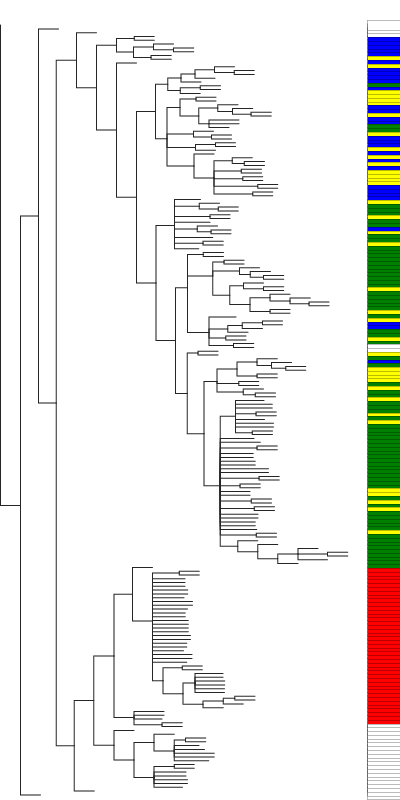

In [157]:
# pip install toytree toyplot biopython pandas matplotlib

import io
import pandas as pd
from Bio import Phylo
import toytree
import toyplot
import toyplot.svg
import matplotlib.cm as cm
import matplotlib.colors as mcolors

NEWICK_FILE = "svdq_constree.bs50.nwk"
OUTGROUP = "ERR310940"

# df must have columns: ["wgs_id", "its_class", "mitotype", "species", "adm2"]

# -------------------------
# 1) Manual categorical colors
# -------------------------
species_colors = {
    "sbovis": "red",
    "shaematobium": "green",
    "sbxsc": "purple",
    "scurassoni": "blue",
    "shxsb": "orange",
    "intercalatum": "grey",
    "guineensis": "grey",
    "matthei": "grey",
    "margrebowiei": "grey",
}
its_class_colors = {
    "SBxSB": "red",
    "SHxSH": "green",
    "SHxSC": "yellow",
    "SCxSC": "blue",
}
mitotype_colors = {
    "SB": "red",
    "SC": "blue",
    "SH": "green",
}

# -------------------------
# 2) Helper functions
# -------------------------
def map_categorical_colors(series, mapping_dict):
    """Map categorical values via user dict; NaN/unmapped -> white."""
    s = series.astype("string")
    return [mapping_dict.get(val, "white") if pd.notna(val) else "white" for val in s]

def map_numeric_cmap(series, cmap="viridis", vmin=0.0, vmax=1.0):
    """Map numeric values to a matplotlib colormap; NaN -> white."""
    vals = pd.to_numeric(series, errors="coerce")
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_func = cm.get_cmap(cmap)
    colors = []
    for v in vals:
        if pd.isna(v):
            colors.append("white")
        else:
            rgba = cmap_func(norm(v))
            colors.append(mcolors.to_hex(rgba))
    return colors

# -------------------------
# 3) Root tree and create toytree object
# -------------------------
tree = Phylo.read(NEWICK_FILE, "newick")
if any(term.name == OUTGROUP for term in tree.get_terminals()):
    tree.root_with_outgroup(OUTGROUP)

buf = io.StringIO()
Phylo.write(tree, buf, "newick")
newick_str = buf.getvalue()
tt = toytree.tree(newick_str)
tip_order = tt.get_tip_labels()

# -------------------------
# 4) Align metadata and build color arrays
# -------------------------
meta = df.set_index("wgs_id").reindex(tip_order)

colors_species = map_categorical_colors(meta["species"],   species_colors)
colors_its     = map_categorical_colors(meta["its_class"], its_class_colors)
colors_mito    = map_categorical_colors(meta["mitotype"],  mitotype_colors)
colors_adm2    = map_numeric_cmap(meta["adm2"], cmap="viridis", vmin=0.0, vmax=1.0)

# -------------------------
# 5) Draw cladogram + phenotype columns
# -------------------------
# --- Create canvas with generous margins ---
canvas = toyplot.Canvas(width=400, height=800)

# bounds = (xmin, xmax, ymin, ymax)
# Expand xmin/xmax to add padding on the left/right so all markers fit comfortably
axes = canvas.cartesian(bounds=(0, 400, 20, 800))
axes.show = False


tt.draw(
    axes=axes,
    layout="r",
    use_edge_lengths=True,
    node_sizes=0,
    tip_labels=False,
    edge_widths=1,
)

# Add aligned phenotype columns
marker_width = 8
marker_px = 5
gap_shift = 40
base_xshift = marker_width * marker_px

tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_its,
                            align=True, xshift=base_xshift, style={"stroke": "black", "stroke-width": 0.2})


#-------------------------
# 7) Save as SVG
# -------------------------
toyplot.svg.render(canvas, "svdq_constree_its")
canvas

/tmp/ipykernel_36688/2099079105.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = cm.get_cmap(cmap)


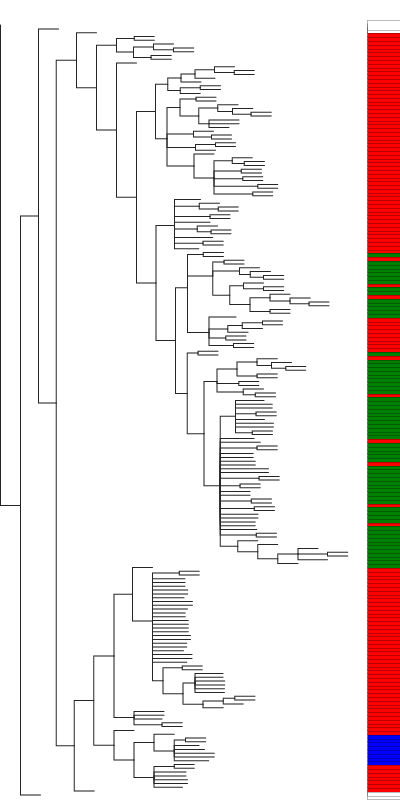

In [156]:
# pip install toytree toyplot biopython pandas matplotlib

import io
import pandas as pd
from Bio import Phylo
import toytree
import toyplot
import toyplot.svg
import matplotlib.cm as cm
import matplotlib.colors as mcolors

NEWICK_FILE = "svdq_constree.bs50.nwk"
OUTGROUP = "ERR310940"

# df must have columns: ["wgs_id", "its_class", "mitotype", "species", "adm2"]

# -------------------------
# 1) Manual categorical colors
# -------------------------
species_colors = {
    "sbovis": "red",
    "shaematobium": "green",
    "sbxsc": "purple",
    "scurassoni": "blue",
    "shxsb": "orange",
    "intercalatum": "grey",
    "guineensis": "grey",
    "matthei": "grey",
    "margrebowiei": "grey",
}
its_class_colors = {
    "SBxSB": "red",
    "SHxSH": "green",
    "SHxSC": "yellow",
    "SCxSC": "blue",
}
mitotype_colors = {
    "SB": "red",
    "SC": "blue",
    "SH": "green",
}

# -------------------------
# 2) Helper functions
# -------------------------
def map_categorical_colors(series, mapping_dict):
    """Map categorical values via user dict; NaN/unmapped -> white."""
    s = series.astype("string")
    return [mapping_dict.get(val, "white") if pd.notna(val) else "white" for val in s]

def map_numeric_cmap(series, cmap="viridis", vmin=0.0, vmax=1.0):
    """Map numeric values to a matplotlib colormap; NaN -> white."""
    vals = pd.to_numeric(series, errors="coerce")
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_func = cm.get_cmap(cmap)
    colors = []
    for v in vals:
        if pd.isna(v):
            colors.append("white")
        else:
            rgba = cmap_func(norm(v))
            colors.append(mcolors.to_hex(rgba))
    return colors

# -------------------------
# 3) Root tree and create toytree object
# -------------------------
tree = Phylo.read(NEWICK_FILE, "newick")
if any(term.name == OUTGROUP for term in tree.get_terminals()):
    tree.root_with_outgroup(OUTGROUP)

buf = io.StringIO()
Phylo.write(tree, buf, "newick")
newick_str = buf.getvalue()
tt = toytree.tree(newick_str)
tip_order = tt.get_tip_labels()

# -------------------------
# 4) Align metadata and build color arrays
# -------------------------
meta = df.set_index("wgs_id").reindex(tip_order)

colors_species = map_categorical_colors(meta["species"],   species_colors)
colors_its     = map_categorical_colors(meta["its_class"], its_class_colors)
colors_mito    = map_categorical_colors(meta["mitotype"],  mitotype_colors)
colors_adm2    = map_numeric_cmap(meta["adm2"], cmap="viridis", vmin=0.0, vmax=1.0)

# -------------------------
# 5) Draw cladogram + phenotype columns
# -------------------------
# --- Create canvas with generous margins ---
canvas = toyplot.Canvas(width=400, height=800)

# bounds = (xmin, xmax, ymin, ymax)
# Expand xmin/xmax to add padding on the left/right so all markers fit comfortably
axes = canvas.cartesian(bounds=(0, 400, 20, 800))
axes.show = False


tt.draw(
    axes=axes,
    layout="r",
    use_edge_lengths=True,
    node_sizes=0,
    tip_labels=False,
    edge_widths=1,
)

# Add aligned phenotype columns
marker_width = 8
marker_px = 5
gap_shift = 40
base_xshift = marker_width * marker_px

tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_mito,
                            align=True, xshift=base_xshift, style={"stroke": "black", "stroke-width": 0.2})

#-------------------------
# 7) Save as SVG
# -------------------------
toyplot.svg.render(canvas, "svdq_constree_mito")
canvas

/tmp/ipykernel_36688/3994887499.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = cm.get_cmap(cmap)


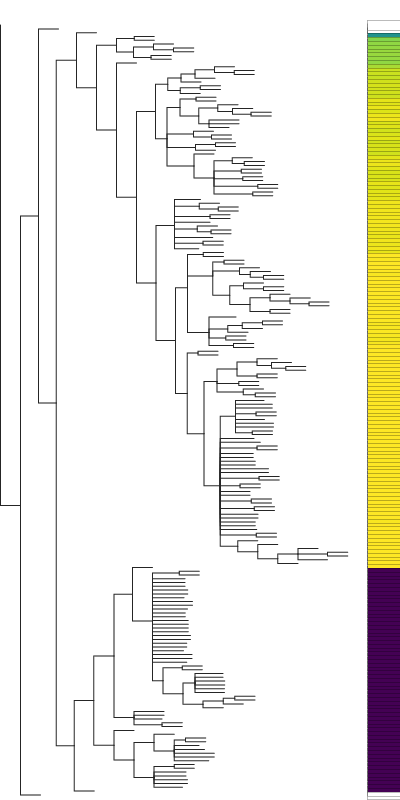

In [155]:
# pip install toytree toyplot biopython pandas matplotlib

import io
import pandas as pd
from Bio import Phylo
import toytree
import toyplot
import toyplot.svg
import matplotlib.cm as cm
import matplotlib.colors as mcolors

NEWICK_FILE = "svdq_constree.bs50.nwk"
OUTGROUP = "ERR310940"

# df must have columns: ["wgs_id", "its_class", "mitotype", "species", "adm2"]

# -------------------------
# 1) Manual categorical colors
# -------------------------
species_colors = {
    "sbovis": "red",
    "shaematobium": "green",
    "sbxsc": "purple",
    "scurassoni": "blue",
    "shxsb": "orange",
    "intercalatum": "grey",
    "guineensis": "grey",
    "matthei": "grey",
    "margrebowiei": "grey",
}
its_class_colors = {
    "SBxSB": "red",
    "SHxSH": "green",
    "SHxSC": "yellow",
    "SCxSC": "blue",
}
mitotype_colors = {
    "SB": "red",
    "SC": "blue",
    "SH": "green",
}

# -------------------------
# 2) Helper functions
# -------------------------
def map_categorical_colors(series, mapping_dict):
    """Map categorical values via user dict; NaN/unmapped -> white."""
    s = series.astype("string")
    return [mapping_dict.get(val, "white") if pd.notna(val) else "white" for val in s]

def map_numeric_cmap(series, cmap="viridis", vmin=0.0, vmax=1.0):
    """Map numeric values to a matplotlib colormap; NaN -> white."""
    vals = pd.to_numeric(series, errors="coerce")
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_func = cm.get_cmap(cmap)
    colors = []
    for v in vals:
        if pd.isna(v):
            colors.append("white")
        else:
            rgba = cmap_func(norm(v))
            colors.append(mcolors.to_hex(rgba))
    return colors

# -------------------------
# 3) Root tree and create toytree object
# -------------------------
tree = Phylo.read(NEWICK_FILE, "newick")
if any(term.name == OUTGROUP for term in tree.get_terminals()):
    tree.root_with_outgroup(OUTGROUP)

buf = io.StringIO()
Phylo.write(tree, buf, "newick")
newick_str = buf.getvalue()
tt = toytree.tree(newick_str)
tip_order = tt.get_tip_labels()

# -------------------------
# 4) Align metadata and build color arrays
# -------------------------
meta = df.set_index("wgs_id").reindex(tip_order)

colors_species = map_categorical_colors(meta["species"],   species_colors)
colors_its     = map_categorical_colors(meta["its_class"], its_class_colors)
colors_mito    = map_categorical_colors(meta["mitotype"],  mitotype_colors)
colors_adm2    = map_numeric_cmap(meta["adm2"], cmap="viridis", vmin=0.0, vmax=1.0)

# -------------------------
# 5) Draw cladogram + phenotype columns
# -------------------------
# --- Create canvas with generous margins ---
canvas = toyplot.Canvas(width=400, height=800)

# bounds = (xmin, xmax, ymin, ymax)
# Expand xmin/xmax to add padding on the left/right so all markers fit comfortably
axes = canvas.cartesian(bounds=(0, 400, 20, 800))
axes.show = False


tt.draw(
    axes=axes,
    layout="r",
    use_edge_lengths=True,
    node_sizes=0,
    tip_labels=False,
    edge_widths=1,
)

# Add aligned phenotype columns
marker_width = 8
marker_px = 5
gap_shift = 40
base_xshift = marker_width * marker_px

tt.annotate.add_tip_markers(axes, marker=f"r{marker_width}x2", size=marker_px, color=colors_adm2,
                            align=True, xshift=base_xshift, style={"stroke": "black", "stroke-width": 0.2})

#-------------------------
# 7) Save as SVG
# -------------------------
toyplot.svg.render(canvas, "svdq_constree_adm")
canvas

In [162]:
df.loc[df["species"] == "shxsb"]

,wgs_id,species,country,locale,its_class,mitotype,adm2,sh_population
145,SRR13579880,shxsb,corsica,na,NaN,SB,NaN,NaN
146,SRR7743801,shxsb,corsica,na,NaN,SB,0.999980,NaN
147,SRR7743802,shxsb,corsica,na,NaN,SB,0.999980,NaN
170,SRR13579879,shxsb,lab,na,NaN,SB,0.510249,NaN
